## Usecase 6 - In Silico Patching

In this tutorial we will learn how to use bluepy to select gids mimicking the approach of standard in vitro multipatch experiments.

Thick-tufted layer 5 pyramidal cells are probably the most studied population of neurons in the neocortex. Usually electrophysiologists try to select those cells guided by experience and by visual clues, such as the shape of their soma or the density of cells in the neighborhood. Depending on the skills and luck of the experimentalist, this approach produces more or less strict selections. In particular, slender-tufted layer 5 pyramidal cells are often mistaken for thick-tufted ones.

Let's then try to select all those neurons and evaluate the relative occurrence of the different mtypes.

As usual, we start by importing some basic packages and creating the bluepy circuit object.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy

from bluepy import Circuit, Cell

In [2]:
circuit = Circuit("/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig")

Invalid absolute path: /gpfs/bbp.cscs.ch/release/l2/2012.07.23/meshes
Have keys ({'CentralHyperColumn'}) that are not defined for section: Run


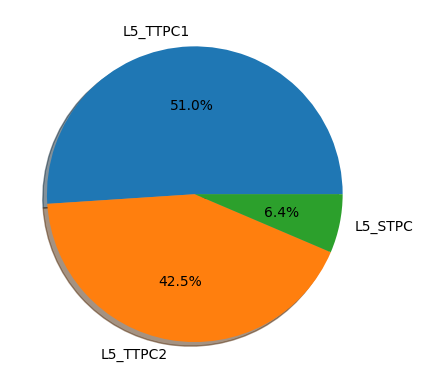

In [3]:
def count_cells(mtype, hypercolumn=2):
    return circuit.cells.count({Cell.MTYPE: mtype, Cell.HYPERCOLUMN: hypercolumn})

# Get L5 PC in the desired HyperColumn
L5_PC_mtypes = ['L5_TTPC1', 'L5_TTPC2', 'L5_STPC']

plt.pie(list(map(count_cells, L5_PC_mtypes)), labels=L5_PC_mtypes, autopct='%1.1f%%', shadow=True);

Considering the small relative occurrence of slender-tufted layer 5 pyramidal cells, we decide to include them all in our initial population. 

The second most important element of in vitro multipatch cell selection is the relative location of patched cells. The experimentalist can obviously patch only what she/he clearly sees, so all the cells should be in the field of view. The usually means that the possible targets are bounded by a box of about 200x200x20 microns.

Furthermore, patching pipettes are placed on manipulators disposed around the microscope with a certain geometry, usually semicircular. The experimentalist assigns specific manipulators to target cells depending on relative position of cells respect to the manipulators, in order to avoid pipette crossing and tetris-like configurations.

For simplicity, here we neglect this last consideration and only focus on getting cells in the right bounding box. We start by getting an random cells, setting its position as the center of the box, and then identifying all the other cells in the box.

In [4]:
# Cell coordinates
cell_xyz = circuit.cells.get({Cell.MTYPE: L5_PC_mtypes, Cell.HYPERCOLUMN: 2}, properties=[Cell.X, Cell.Y, Cell.Z])

gids = cell_xyz.index.values

# Extract one random cell as center of the box
center_gid = np.random.choice(gids)
# for reproducibility purpose we fix the center gid
center_gid = 77980
cx, cy, cz = cell_xyz.loc[center_gid]

# Bounding box parameters
dx, dy, dz = 100.0, 100.0, 10.0

inner = cell_xyz.query('(abs(x - @cx) < @dx) and (abs(y - @cy) < @dy) and (abs(z - @cz) < @dz)')
outer = cell_xyz.loc[np.setdiff1d(gids, inner.index)]
# Exclude center of the box
inner = inner.drop(center_gid)

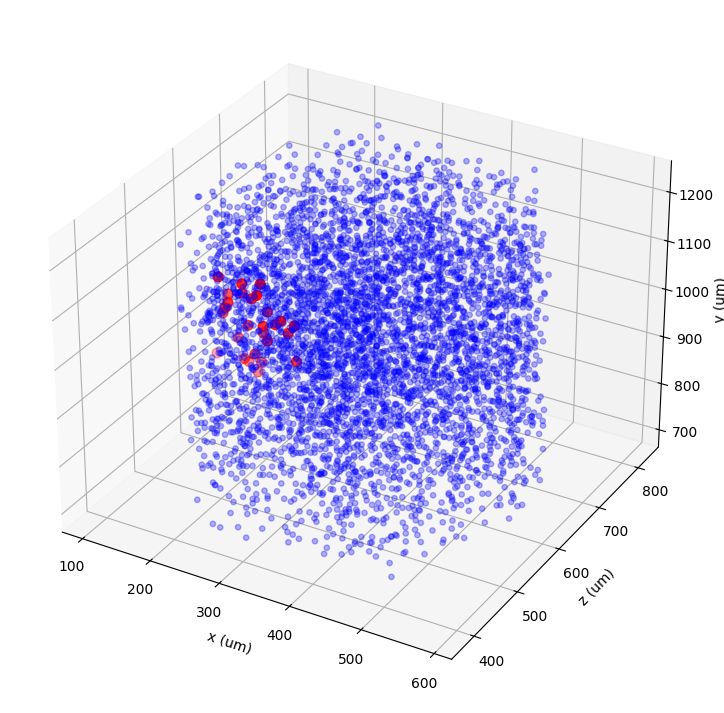

In [5]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Show outer cells in blue
ax.scatter(outer.x, outer.z, outer.y, s=15, c='b', alpha=0.3)

# Show inner cells in red
ax.scatter(inner.x, inner.z, inner.y, s=50, c='r')

ax.set_xlabel('x (um)')
ax.set_ylabel('z (um)')
ax.set_zlabel('y (um)');

In the previous example we learned how to extract cell positions, we can use this capability to evaluate the dependence of connection probability and cell distance.

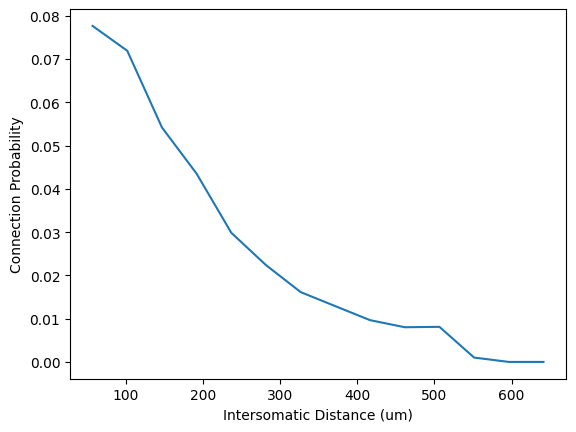

In [6]:
sample_xyz = cell_xyz.sample(300, random_state=1)
sample_gids = sample_xyz.index.values

dist = scipy.spatial.distance.cdist(sample_xyz, sample_xyz)

connected_mask = []
for post_gid in sample_gids:
    connected_gids = circuit.connectome.afferent_gids(post_gid)
    connected_mask.append(np.in1d(sample_gids, connected_gids))
connected_mask = np.stack(connected_mask)

distance_conn = dist[connected_mask]
distance_unconn = dist[~(connected_mask | np.identity(len(sample_gids), dtype=bool))]

leftedge = min(min(distance_conn), min(distance_unconn))
rightedge = max(max(distance_conn), max(distance_unconn))
bins = np.linspace(leftedge, rightedge, num=15)

hist_unconn, bins_unconn = np.histogram(distance_unconn, bins=bins)
hist_conn, bins_conn = np.histogram(distance_conn, bins=bins)

p = np.array(hist_conn, dtype=float)/(hist_conn + hist_unconn)

plt.plot(bins[1:], p)
plt.ylabel('Connection Probability')
plt.xlabel('Intersomatic Distance (um)');

In [7]:
plt.close('all')